In [1]:
# Imports and initial setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, ConfusionMatrixDisplay, 
                             classification_report)
from joblib import dump, load

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load and preprocess data
df = pd.read_csv("enron_spam_data.csv")
# Drop unnecessary columns and rename
df = df.drop(['Message ID', 'Date'], axis=1)
df = df.rename(columns={'Spam/Ham': 'Type'})
# Handle missing values
print("Subject NaN count:", len(df[df['Subject'].isnull()]))
print("Message NaN count:", len(df[df['Message'].isnull()]))
df = df.dropna(subset=['Subject', 'Message'])
# Encode labels (0 = ham, 1 = spam)
encoder = LabelEncoder()
df['Type'] = encoder.fit_transform(df['Type'])

Subject NaN count: 289
Message NaN count: 371


In [5]:
print("Subject NaN count:", len(df[df['Subject'].isnull()]))
print("Message NaN count:", len(df[df['Message'].isnull()]))

Subject NaN count: 0
Message NaN count: 0


In [3]:
# Text vectorization
vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=2,
    max_df=0.95,
    stop_words='english'
)
all_text = df['Subject'].astype(str) + ' ' + df['Message'].astype(str)
X = vectorizer.fit_transform(all_text).toarray()  # Convert to dense for consistency
y = df['Type'].values

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
# Define and train models
models = {
    'Naive Bayes': MultinomialNB(),
    'XGBoost': XGBClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=5, 
        random_state=42, eval_metric='logloss', enable_categorical=False
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=50, max_depth=10, min_samples_split=5, 
        random_state=42, n_jobs=-1
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=5, 
        random_state=42, n_jobs=-1, verbose=-1
    ),
    'SVM': SVC(kernel='linear', probability=True, random_state=42)
}

# Train all models and store predictions
predictions = {}
for name, model in models.items():
    if name == 'XGBoost':
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    else:
        model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

In [7]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance Metrics:")
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    disp.plot(cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    return f1  # Return F1 score for ensemble weighting


Naive Bayes Performance Metrics:
Accuracy: 0.9847
F1 Score: 0.9848
Precision: 0.9823
Recall: 0.9873

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3307
           1       0.98      0.99      0.98      3315

    accuracy                           0.98      6622
   macro avg       0.98      0.98      0.98      6622
weighted avg       0.98      0.98      0.98      6622



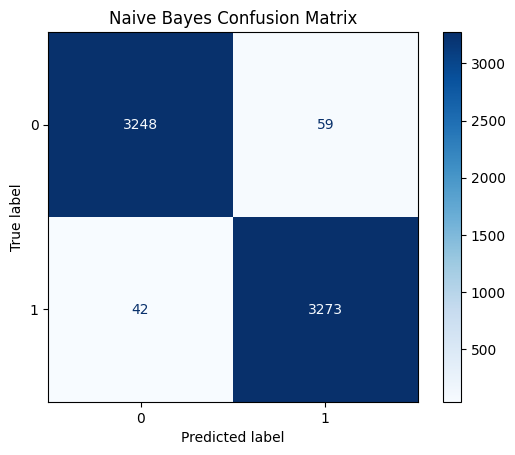


XGBoost Performance Metrics:
Accuracy: 0.9612
F1 Score: 0.9624
Precision: 0.9336
Recall: 0.9931

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3307
           1       0.93      0.99      0.96      3315

    accuracy                           0.96      6622
   macro avg       0.96      0.96      0.96      6622
weighted avg       0.96      0.96      0.96      6622



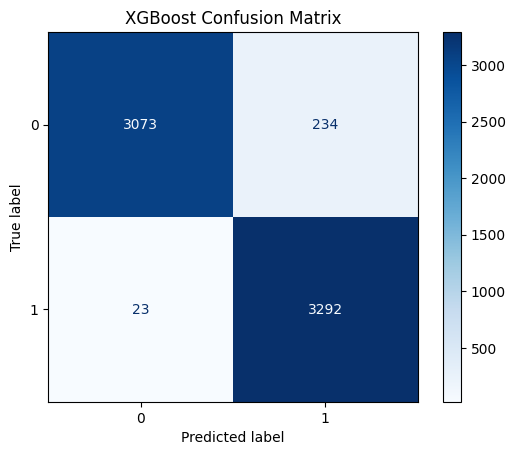


Random Forest Performance Metrics:
Accuracy: 0.9133
F1 Score: 0.9201
Precision: 0.8542
Recall: 0.9970

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3307
           1       0.85      1.00      0.92      3315

    accuracy                           0.91      6622
   macro avg       0.93      0.91      0.91      6622
weighted avg       0.93      0.91      0.91      6622



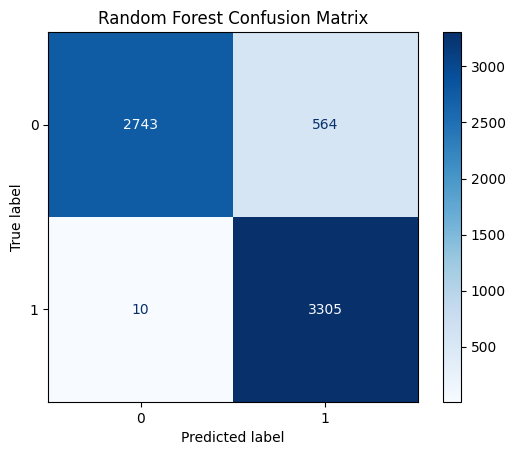


LightGBM Performance Metrics:
Accuracy: 0.9613
F1 Score: 0.9626
Precision: 0.9344
Recall: 0.9925

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3307
           1       0.93      0.99      0.96      3315

    accuracy                           0.96      6622
   macro avg       0.96      0.96      0.96      6622
weighted avg       0.96      0.96      0.96      6622



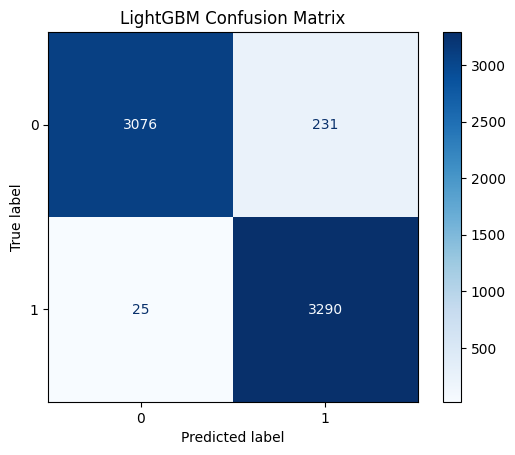


SVM Performance Metrics:
Accuracy: 0.9909
F1 Score: 0.9910
Precision: 0.9874
Recall: 0.9946

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3307
           1       0.99      0.99      0.99      3315

    accuracy                           0.99      6622
   macro avg       0.99      0.99      0.99      6622
weighted avg       0.99      0.99      0.99      6622



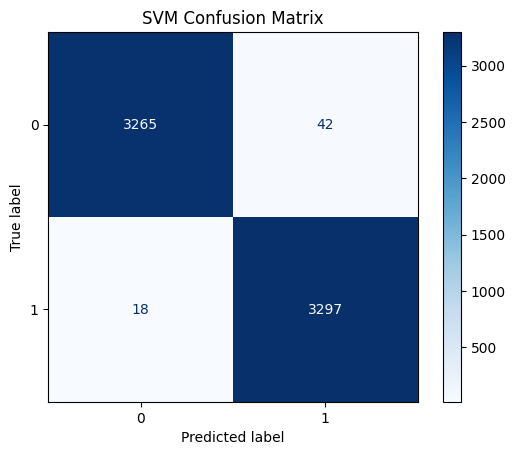

In [8]:
# Evaluate all models and collect F1 scores
f1_scores = {}
for name, pred in predictions.items():
    f1_scores[name] = evaluate_model(y_test, pred, name)


Ensemble Performance Metrics:
Accuracy: 0.9897
F1 Score: 0.9898
Precision: 0.9836
Recall: 0.9961

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3307
           1       0.98      1.00      0.99      3315

    accuracy                           0.99      6622
   macro avg       0.99      0.99      0.99      6622
weighted avg       0.99      0.99      0.99      6622



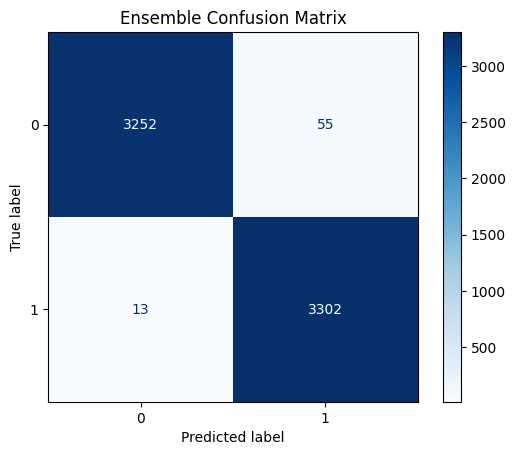

In [9]:
# Ensemble with weighted voting
ensemble_estimators = [(name, model) for name, model in models.items()]
weights = [f1_scores[name] for name in models.keys()]
ensemble_clf = VotingClassifier(
    estimators=ensemble_estimators, voting='soft', weights=weights
)
ensemble_clf.fit(X_train, y_train)
y_pred_ensemble = ensemble_clf.predict(X_test)
f1_scores['Ensemble'] = evaluate_model(y_test, y_pred_ensemble, 'Ensemble')

In [10]:
# Custom input testing function
def test_custom_input(text, model, model_name):
    text_vectorized = vectorizer.transform([text]).toarray()
    prediction = model.predict(text_vectorized)
    result = "Not Spam" if prediction[0] == 0 else "Spam"
    print(f"{model_name} prediction: {result}")

# Test emails
test_email_formal = '''
# Email Template: Project Update Request
## Subject: Q1 Project Progress Review - Request for Update
Dear [Recipient Name],
I hope this email finds you well. I am writing to request an update on our current project milestones and progress for the first quarter.
### Key Points of Interest:
- Current status of project deliverables
- Any challenges or obstacles encountered
- Projected timeline for completion
- Resource requirements or potential adjustments needed
Could we schedule a brief meeting this week to discuss these items in more detail? I'm available [list 2-3 specific time slots] and am happy to accommodate your schedule.
Please find attached the latest project tracking document for your reference.
Best regards,
[Your Name]
[Your Title]
[Contact Information]
**Attachments:** Q1_Project_Tracker.xlsx
'''

test_email_short = '''hi ,how are you?'''

# Test formal email
print("\nTesting Formal Email:")
for name, model in models.items():
    test_custom_input(test_email_formal, model, name)
test_custom_input(test_email_formal, ensemble_clf, "Ensemble")

# Test short email
print("\nTesting Short Email:")
for name, model in models.items():
    test_custom_input(test_email_short, model, name)
test_custom_input(test_email_short, ensemble_clf, "Ensemble")


Testing Formal Email:
Naive Bayes prediction: Not Spam
XGBoost prediction: Not Spam
Random Forest prediction: Not Spam
LightGBM prediction: Not Spam
SVM prediction: Not Spam
Ensemble prediction: Not Spam

Testing Short Email:
Naive Bayes prediction: Spam
XGBoost prediction: Spam
Random Forest prediction: Spam
LightGBM prediction: Spam
SVM prediction: Spam
Ensemble prediction: Spam


In [14]:
print("\nTesting Formal Email with SVM:")
test_custom_input(test_email_formal, models['SVM'], 'SVM')

print("\nTesting Short Email with SVM:")
test_custom_input(test_email_short, models['SVM'], 'SVM')


Testing Formal Email with SVM:
SVM prediction: Not Spam

Testing Short Email with SVM:
SVM prediction: Spam


In [ ]:
print("\nTesting Formal Email:")
for name, model in models.items():
    test_custom_input(test_email_formal, model, name)
test_custom_input(test_email_formal, ensemble_clf, "Ensemble")

In [11]:
# Save models and vectorizer
models_dir = r'C:\Users\Ashish Mahendran\New folder (16)\models_improved'
os.makedirs(models_dir, exist_ok=True)

try:
    dump(vectorizer, os.path.join(models_dir, 'vectorizer.joblib'))
    print("Vectorizer saved successfully!")
    for name, model in models.items():
        dump(model, os.path.join(models_dir, f'{name.lower().replace(" ", "_")}_model.joblib'))
        print(f"{name} model saved successfully!")
    dump(ensemble_clf, os.path.join(models_dir, 'ensemble_model.joblib'))
    print("Ensemble model saved successfully!")
    print(f"\nAll models saved in: {models_dir}")
except Exception as e:
    print(f"Error saving models: {str(e)}")

Vectorizer saved successfully!
Naive Bayes model saved successfully!
XGBoost model saved successfully!
Random Forest model saved successfully!
LightGBM model saved successfully!
SVM model saved successfully!
Ensemble model saved successfully!

All models saved in: C:\Users\Ashish Mahendran\New folder (16)\models_improved


In [12]:
# Identify and save best model
best_model_name = max(f1_scores, key=f1_scores.get)
best_model = models.get(best_model_name, ensemble_clf if best_model_name == 'Ensemble' else None)
dump(best_model, os.path.join(models_dir, 'best_model.joblib'))
print(f"Best model '{best_model_name}' (F1: {f1_scores[best_model_name]:.4f}) saved successfully!")

Best model 'SVM' (F1: 0.9910) saved successfully!
